In [ ]:
import os
import argparse
import time
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from argparse import Namespace
from scipy.integrate import odeint as scipy_odeint
from torchdiffeq import odeint_adjoint as tf_odeint
from tqdm.notebook import  tqdm


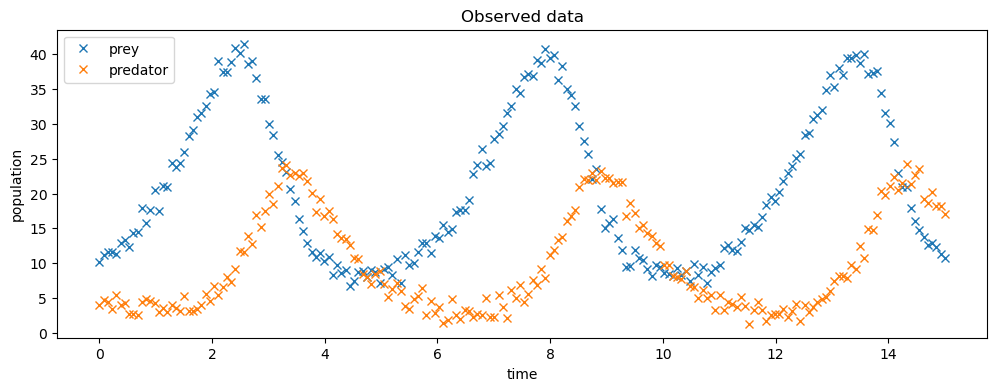

In [12]:

def get_observed_data():
    # Definition of parameters
    a,b,c,d = 1.0, 0.1, 1.5, 0.75

    # initial population of rabbits and foxes
    y0 = [10.0, 5.0]
    # size of data
    size = 200
    # time lapse
    time = 15
    t = np.linspace(0, time, size)

    # Lotka - Volterra equation
    def dX_dt(y, t, a, b, c, d):
        """Return the growth rate of fox and rabbit populations."""
        return np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])

    observed = scipy_odeint(dX_dt, y0=y0, t=t, rtol=0.01, args=(a, b, c, d))
    noise = np.random.normal(size=(size, 2))
    observed += noise

    return t, y0, observed

t, y0, observed = get_observed_data()
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, observed[:, 0],"x", label="prey")
ax.plot(t, observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend()


In [13]:

class CompetitionModel(torch.nn.Module):
    def __init__(self):
        super(CompetitionModel, self).__init__()

        self.a = nn.Parameter(torch.tensor(0.5))
        self.b = nn.Parameter(torch.tensor(0.5))
        self.c = nn.Parameter(torch.tensor(0.5))
        self.d = nn.Parameter(torch.tensor(0.5))

        self.ys = nn.Parameter(torch.tensor([10., 5.]))

    def forward(self, t, y):
        # np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])
        # w = self.w.type_as(y).to(y.device).clone().detach()
        if t == 0:
            y = self.ys

        y0, y1 = y

        # a * y[0] - b * y[0] * y[1]
        _y0 = self.a * y0 - self.b * y0 * y1

        # -c * y[1] + d * b * y[0] * y[1]
        _y1 = -1 * self.c * y1 + self.d* self.b * y0 * y1

        _y = torch.stack([_y0, _y1])
        return _y

ode_func = CompetitionModel()
device = "cpu"
params = ode_func.parameters()

batch_y0, batch_t, batch_y = torch.tensor(y0, dtype=torch.float32).to(device), torch.tensor(t, dtype=torch.float32).to(device), torch.tensor(observed, dtype=torch.float32).to(device)

optimizer = optim.AdamW(params, lr=0.1)
loss_func = nn.MSELoss()

epoch = 100000
pbar =tqdm(total=epoch, ascii=True)

for itr in range(epoch):
    optimizer.zero_grad()
    pred_y = tf_odeint(ode_func, batch_y0, batch_t, method="rk4").to(device)
    loss = loss_func( pred_y, batch_y)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _real = f"a:1.0, b:0.1, c:1.5, d:0.75"
        _now = ", ".join([f"{n}:{p.detach().numpy():.4f}" for n,p in ode_func.named_parameters()])
        pbar.set_description(f'Iter {itr:04d} | Total Loss {loss.item():.6f} real:{_real} now:{_now}')
        pbar.update(1)
        pbar.refresh()

_now = ", ".join([f"{n}:{p.detach().numpy()}" for n,p in ode_func.named_parameters()])
print(_now)


  0%|          | 0/100000 [00:00<?, ?it/s]

TypeError: unsupported format string passed to numpy.ndarray.__format__